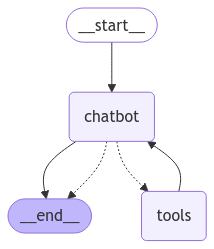

In [1]:
from dotenv import load_dotenv
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

import sys
sys.path.append('../..')
from agent_tools.custom_tools import search_news


class State(TypedDict):
    messages: Annotated[List, add_messages]


@tool
def search_keyword(query:str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    return [
        {
            "url": news["link"], 
            "content": news["content"]
        } for news in search_news(query)[:5]
    ]


load_dotenv()
tools = [search_keyword]
llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
        "dummy_data": "[chatbot] 호출, dummy data"
    }


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [2]:
from langchain_core.runnables import RunnableConfig

question = "한국 관련 최신 뉴스를 알려주세요. 외국인이 좋아할만한 주제에서 찾아주세요."
input = State(messages=[("user", question)])
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="values",
    interrupt_before=["tools"],  # tools 실행 전 interrupt(tools 노드 실행 전 중단)
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        print(value)

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")


[messages]

[HumanMessage(content='한국 관련 최신 뉴스를 알려주세요. 외국인이 좋아할만한 주제에서 찾아주세요.', additional_kwargs={}, response_metadata={}, id='aa860667-cc30-4efb-ba86-a58c20fed1ba')]

[messages]

[HumanMessage(content='한국 관련 최신 뉴스를 알려주세요. 외국인이 좋아할만한 주제에서 찾아주세요.', additional_kwargs={}, response_metadata={}, id='aa860667-cc30-4efb-ba86-a58c20fed1ba'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uhQMEodM1Gp80gXdkY3BpT4v', 'function': {'arguments': '{"query":"Korea"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 64, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c761a7e5

In [3]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태
snapshot.next


('tools',)

In [4]:
existing_message = snapshot.values["messages"][-1]
print(existing_message.tool_calls)

[{'name': 'search_keyword', 'args': {'query': 'Korea'}, 'id': 'call_uhQMEodM1Gp80gXdkY3BpT4v', 'type': 'tool_call'}]


In [5]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_uhQMEodM1Gp80gXdkY3BpT4v)
 Call ID: call_uhQMEodM1Gp80gXdkY3BpT4v
  Args:
    query: Korea


C:\Users\kwest\AppData\Local\Temp\ipykernel_16832\582841012.py:28: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  } for news in search_news(query)[:5]


================================= Tool Message =================================
Name: search_keyword

[{"url": "https://n.news.naver.com/mnews/article/018/0005926843?sid=101", "content": "한국맥도날드, RMHC Korea에 역대 최대 기부금 8.1억원 전달"}, {"url": "https://n.news.naver.com/mnews/article/001/0015164796?sid=104", "content": "(LEAD) N. Korea warns of taking action 'more intensively' over S. Korea, U.S., Japan's air drills"}, {"url": "https://n.news.naver.com/mnews/article/001/0015164568?sid=104", "content": "(EDITORIAL from Korea JoongAng Daily on Jan. 17)"}, {"url": "https://n.news.naver.com/mnews/article/001/0015164567?sid=104", "content": "(EDITORIAL from Korea Times on Jan. 17)"}, {"url": "https://n.news.naver.com/mnews/article/001/0015163972?sid=104", "content": "S. Korea stresses N.K. denuclearization 'unanimous goal' after Rubio remarks"}]
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_NlsVLsbeXSLOoxFlNcHywLnv)
 Call ID: c

In [6]:
to_replay = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):
    # 메시지 수 및 다음 상태 출력
    print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
    print("-" * 80)
    # 특정 상태 선택 기준: 채팅 메시지 수
    if len(state.values["messages"]) == 3:
        to_replay = state


메시지 수:  11 다음 노드:  ()
--------------------------------------------------------------------------------
메시지 수:  10 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  8 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  7 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  6 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  5 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  4 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  

In [7]:
print(to_replay.next)
print(to_replay.config)


('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd48f8-3c88-62ed-8002-4681c887342d'}}


In [8]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================= Tool Message =================================
Name: search_keyword

[{"url": "https://n.news.naver.com/mnews/article/018/0005926843?sid=101", "content": "한국맥도날드, RMHC Korea에 역대 최대 기부금 8.1억원 전달"}, {"url": "https://n.news.naver.com/mnews/article/001/0015164796?sid=104", "content": "(LEAD) N. Korea warns of taking action 'more intensively' over S. Korea, U.S., Japan's air drills"}, {"url": "https://n.news.naver.com/mnews/article/001/0015164568?sid=104", "content": "(EDITORIAL from Korea JoongAng Daily on Jan. 17)"}, {"url": "https://n.news.naver.com/mnews/article/001/0015164567?sid=104", "content": "(EDITORIAL from Korea Times on Jan. 17)"}, {"url": "https://n.news.naver.com/mnews/article/001/0015163972?sid=104", "content": "S. Korea stresses N.K. denuclearization 'unanimous goal' after Rubio remarks"}]
================================== Ai Message ==================================

다음은 외국인들이 관심 가질 만한 한국 관련 최신 뉴스입니다:

1. [한국맥도날드, RMHC Korea에 역대 최대 기부금 8

여기 외국인이 흥미로워할만한 한국 관련 최신 뉴스입니다:

### 문화 및 관광
1. **Korea Grand Sale 시작**: "Korea Grand Sale kicks off in largest-ever scale" - 한국의 대규모 쇼핑 행사인 코리아 그랜드 세일이 역대 최대 규모로 시작되었습니다. [읽기](https://n.news.naver.com/mnews/article/044/0000265677?sid=104)

2. **한국 관광 재개**: "Travel agency announces reopening of tourism to N. Korea's Rason for foreigners" - 외국인 관광객을 위한 북한 라선 관광이 재개됩니다. [읽기](https://n.news.naver.com/mnews/article/001/0015165144?sid=104)

3. **K-콘텐츠 보호 강화**: "S. Korea to bolster efforts to enhance IP protection of K-content" - 한국은 K-콘텐츠의 지적 재산권 보호를 강화하기 위한 노력을 기울이고 있습니다. [읽기](https://n.news.naver.com/mnews/article/001/0015160518?sid=104)

### 음식
1. **한국 음식의 정체성**: "Chef Edward Lee wins Korea Image Awards, calls Korean food his identity" - 셰프 에드워드 리가 한국 음식은 그의 정체성을 나타낸다고 말하며 한국 이미지 어워드를 수상했습니다. [읽기](article/)

### 엔터테인먼트
1. **K-pop 새로운 방향**: "SM's British Boy Group dearALICE to Pre-Release Debut Track in Korea – A New Direction for K-pop?" - SM 엔터테인먼트의 영국 보이 그룹 dearALICE가 한국에서 데뷔 트랙을 사전 공개할 예정입니다. [읽기](article/)

이 뉴스들은 한국의 문화, 음식, 관광, 그리고 엔터테인먼트와 관련된 다양한 주제를 포함하고 있어 외국인들에게 흥미로울 것입니다.